In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "../brazilian_coin/input"]).decode("utf8"))

classification_dataset.tar.gz
classification_dataset.tar.gz.zip
regression_dataset.tar.gz
regression_dataset.tar.gz.zip
regression_sample



In [2]:
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

Working with 968 images
Image examples: 
100_1477281750.jpg


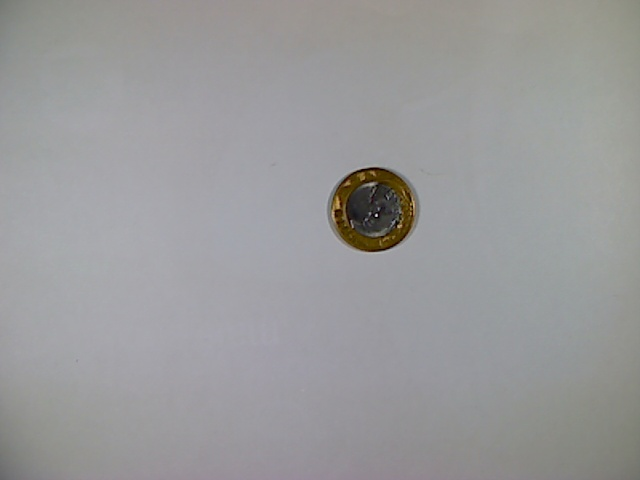

100_1477281756.jpg


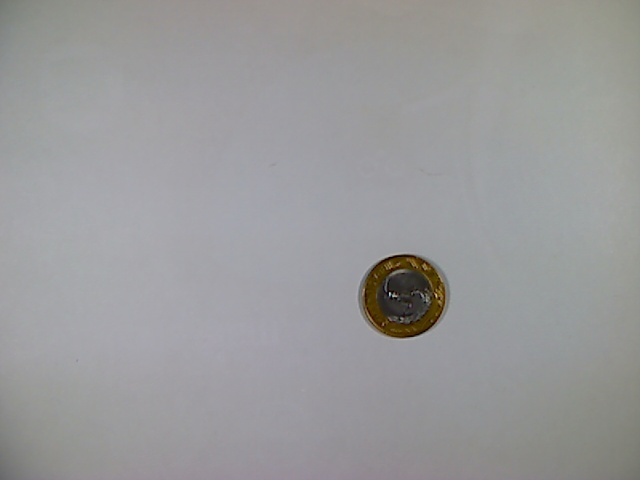

In [3]:
folder = "../brazilian_coin/input/regression_sample"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(40, 42):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))

opencv를 설치해서 동전 이미지를 잘라와야 한다. 

http://wandlab.blogspot.kr/2016/11/python3-opencv3-anaconda3.html

python3라서 설치할때는 opencv3로 설치해야 하는 듯

In [4]:
import cv2
import os
import shutil
import random
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

%matplotlib inline

In [5]:
import tarfile

image_list = []
label_list = []

tar = tarfile.open('../brazilian_coin/input/classification_dataset.tar.gz', "r:gz")
for tarinfo in tar:
    tar.extract(tarinfo.name)
    if(tarinfo.name[-4:] == '.jpg'):
        image_list.append(np.array(cv2.imread(tarinfo.name, cv2.IMREAD_COLOR)))
        label_list.append(tarinfo.name.split('_')[0])
    if(tarinfo.isdir()):
        os.rmdir(tarinfo.name)
    else:
        os.remove(tarinfo.name)    
   
tar.close()

images = np.array(image_list)
labels = np.array(label_list)

coins 만 추출해내는 함수 정의

In [6]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(
        cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)

        frames.append(resized)

    return np.array(frames), radiuses

코인 추출하기

In [7]:
# The coins images are extracted from original images using extract_coins function
scaled = []
scaled_labels = []
for nominal, image in zip(labels, images):
    #print(image)
    prepared, _ = extract_coins(image)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)

Convert string labels to categorical for use in model training

기존에는 keras로 되어있었던 one hot encoding 을 텐서플로우 방식으로 바꿈

In [8]:
# Convert the string labels to int
print(np.array(scaled_labels).shape)
print(set(scaled_labels))
label_classes = set(scaled_labels)

labels_dict = {}
for v_i, v in enumerate(label_classes):
    labels_dict[v] = v_i
        
print(labels_dict)

labels = []
for label in scaled_labels:
    labels.append(labels_dict[label])
    
print(set(labels))    

y_binary = tf.one_hot(labels,depth=5)

print(y_binary)

(3035,)
{'all/25', 'all/100', 'all/10', 'all/5', 'all/50'}
{'all/25': 0, 'all/100': 1, 'all/10': 2, 'all/5': 3, 'all/50': 4}
{0, 1, 2, 3, 4}
Tensor("one_hot:0", shape=(3035, 5), dtype=float32)


In [10]:
np.shape(scaled_labels)

(3035,)

In [11]:
np.shape(scaled)

(3035, 100, 100, 3)

In [9]:
with tf.Session() as sess:
    print(sess.run(y_binary))

[[ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


show image samples

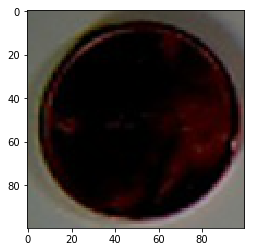

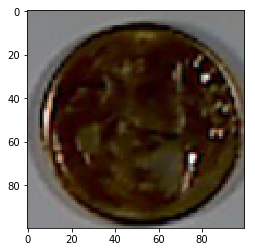

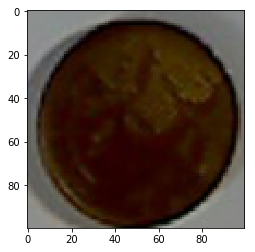

In [10]:
# Plot sample images from list
for image_item in random.sample(scaled, 3): 
    image = np.array(image_item)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

modeling

test data and train data setting

In [40]:
np.shape(scaled)

(3035, 100, 100, 3)

In [24]:
np.shape(scaled_labels)

(3035,)

In [25]:
len(scaled_labels)

3035

In [39]:
len(scaled)

3035

In [43]:
No_scaled=(scaled[0]-127.5)/127.5

In [56]:
from sklearn.cross_validation import train_test_split
#Splitting 
X_train, X_test, y_train, y_test = train_test_split(scaled, scaled_labels, test_size=0.2, random_state=33)

print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 2428, Test set size: 607


In [48]:
np.shape(X_train)

(2428, 100, 100, 3)

In [49]:
np.shape(X_test)

(607, 100, 100, 3)

In [58]:
np.shape(y_train)

(2428,)

In [60]:
# Convert the string labels to int
print(np.array(scaled_labels).shape)
print(set(scaled_labels))
label_classes = set(scaled_labels)

labels_dict = {}
for v_i, v in enumerate(label_classes):
    labels_dict[v] = v_i
        
print(labels_dict)

train_labels = []
for train_label in y_train:
    train_labels.append(labels_dict[train_label])
    
test_labels = []
for test_label in y_test:
    test_labels.append(labels_dict[test_label])
    
print(set(labels))    

y_train = tf.one_hot(train_labels,depth=5)
y_test = tf.one_hot(test_labels,depth=5)

print(y_train)
print(y_test)

(3035,)
{'all/25', 'all/100', 'all/10', 'all/5', 'all/50'}
{'all/25': 0, 'all/100': 1, 'all/10': 2, 'all/5': 3, 'all/50': 4}
{0, 1, 2, 3, 4}
Tensor("one_hot_2:0", shape=(2428, 5), dtype=float32)
Tensor("one_hot_3:0", shape=(607, 5), dtype=float32)


# modeling

In [61]:
# truncated normal distribution에 기반해서 랜덤한 값으로 초기화
def weight_variable(shape):
    # tf.truncated_normal:
    # Outputs random values from a truncated normal distribution.
    # values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# 0.1로 초기화
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [62]:
# convolution & max pooling
# vanila version of CNN
# x (아래 함수들에서) : A 4-D `Tensor` with shape `[batch, height, width, channels]`
def conv2d(x, W):
    # stride = 1, zero padding은 input과 output의 size가 같도록.
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [113]:
x = tf.placeholder("float", shape=[None, 100,100,3])
y_ = tf.placeholder("float", shape=[None, 5])

In [87]:
# [5, 5, 1, 32]: 5x5 convolution patch, 1 input channel, 32 output channel.
# MNIST의 pixel은 0/1로 표현되는 1개의 벡터이므로 1 input channel임.
# CIFAR-10 같이 color인 경우에는 RGB 3개의 벡터로 표현되므로 3 input channel일 것이다.
# Shape을 아래와 같이 넣으면 넣은 그대로 5x5x1x32의 텐서를 생성함.
W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])
# 최종적으로, 32개의 output channel에 대해 각각 5x5의 convolution patch (filter) weight 와 1개의 bias 를 갖게 됨.

# x는 [None, 784] (위 placeholder에서 선언). 이건 [batch, 28*28] 이다.
# x_image는 [batch, 28, 28, 1] 이 됨. -1은 batch size를 유지하는 것이고 1은 color channel.
x_image = tf.reshape(x, [-1,100,100,3])

# 이제, x_image를 weight tensor와 convolve하고 bias를 더한 뒤 ReLU를 적용하자. 그리고 마지막으론 max pooling.
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [88]:
# channels (features) : 32 => 64
# 5x5x32x64 짜리 weights.
W_conv2 = weight_variable([5, 5, 32 ,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [89]:
# Densely connected layer
# 7*7*64는 h_pool2의 output (7*7의 reduced image * 64개의 채널). 1024는 fc layer의 뉴런 수.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) # -1은 batch size를 유지하는 것.
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [90]:
# keen_prob은 dropout을 적용할지 말지에 대한 확률임. 이를 이용해서 training 동안만 드롭아웃을 적용하고 testing 때는 적용하지 않는다.
# training & evaluation 코드를 보니 keen_prob = 1.0일때 dropout off 인 듯.
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [91]:
W_fc2 = weight_variable([1024, 5])
b_fc2 = bias_variable([5])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## batch

In [92]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [98]:
sess.run(tf.global_variables_initializer())
onehot_train = sess.run(y_train)
batch_size=len(X_train)//50
print('batch_size',batch_size)

batch_size 48


In [99]:
len(X_train)

2428

In [114]:
 for j in range(0, 5):
        avg_accuracy_val = 0.
        batch_count = 0.
        for i in range(0, len(X_train), batch_size):
            batch_data = X_train[i:i+batch_size]
            batch_onehot_vals = onehot_train[i:i+batch_size]
            _, accuracy_val = sess.run([train_step, accuracy], feed_dict={x: batch_data, y: batch_onehot_vals})
            avg_accuracy_val += accuracy_val
            batch_count += 1.
        avg_accuracy_val /= batch_count
        print('Epoch {}. Avg accuracy {}'.format(j, avg_accuracy_val))

InvalidArgumentError: Shape [-1,100,100,3] has negative dimensions
	 [[Node: Placeholder_4 = Placeholder[dtype=DT_FLOAT, shape=[?,100,100,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_4', defined at:
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-cbeaa43ab0bb>", line 1, in <module>
    x = tf.placeholder("float", shape=[None, 100,100,3])
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\user\Anaconda3\envs\tensorflow35\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,100,100,3] has negative dimensions
	 [[Node: Placeholder_4 = Placeholder[dtype=DT_FLOAT, shape=[?,100,100,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [100]:
np.shape(X_train)

(2428, 100, 100, 3)

In [104]:
np.shape(X_train[1:50])

(49, 100, 100, 3)

In [111]:
np.shape(onehot_train[1:50])

(49, 5)

In [ ]:
onehot_train